In [72]:
# Required packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pylab import *
from casadi import *
from scipy.linalg import logm, expm
from IPython.display import display, Markdown
import time
import math
import itertools



In [99]:
# Parameter values
normalization_value = 1e9
δ = 0.02
α = 0.045007414
κ = 2.094215255
Pe = 0
ζ = 1.66e-4 * normalization_value
Pa_1 = 38.29988757
Pa_2 = 44.75876047

# Parameters
parameters = [
    ("normalization", normalization_value),
    ("δ", δ),
    ("α", α),
    ("κ", κ),
    ("$P^e$", Pe),
    ("ζ", ζ),
    ("$P^A_1$", Pa_1),
    ("$P^A_2$", Pa_2)
]


# Generate Markdown table
markdown_table = "| Parameter | Value |\n|---|---|\n"
for param, value in parameters:
    markdown_table += f"| {param} | {value} |\n"

# Display the Markdown table
display(Markdown(markdown_table))


| Parameter | Value |
|---|---|
| normalization | 1000000000.0 |
| δ | 0.02 |
| α | 0.045007414 |
| κ | 2.094215255 |
| $P^e$ | 0 |
| ζ | 166000.0 |
| $P^A_1$ | 38.29988757 |
| $P^A_2$ | 44.75876047 |


Let us begin with a definition of the important state vectors
\begin{array}{llll}
Z_t &  := & (Z_t^1, Z_t^2, ..., Z_t^I) & \textrm{ vector of area used for agriculture expressed in hectares} \cr
X_t & := & (X_t^1, X_t^2, ..., X_t^I) & \textrm{ vector of carbon captured expressed in Mg CO2e (CO2 equivalent)  } \cr
A_t & := & (A_t^1, A_t^2, ..., A_t^I) & \textrm{ vector of agricultural output} 
\end{array}
where
$$
0 \le Z_t^i \le {\bar z}_i
$$
and define
$$
\tilde X_t = \sum_i^I X_t^i
$$

In [74]:
#Site Data
 # Read data file
n='global'
file=f"data/calibration_{n}Model.csv"
df = pd.read_csv(file)
df = df.sort_values(by=[f'theta_{n}'])

z0_list = df[f'z_2017_{n}'].to_numpy() # initial distribution of agriculture
γ_list  = df[f'gamma_{n}'].to_numpy()  #  distribution of gammas (aka impact of cutting down forests)
x0_list = γ_list * (df[f'forestArea_2017_ha_{n}'].to_numpy())# initial distribution of carbon absoprtion of the amazon
θ_list  = df[f'theta_{n}'].to_numpy() #  distribution of the productivity parameters

Z0_list = z0_list/ normalization_value
X0_list = x0_list/ normalization_value

z̄ = (df[f'zbar_2017_{n}'].to_numpy() )/normalization_value # distribution of the upper bound of agriculture in each site
n = len(z̄) # total number of sites 

Let us define the state variable vector 

$$
Y_t = \begin{bmatrix}
Z^1_t\\
Z^2_t\\
\vdots\\
Z^I_t\\
\tilde X_t\\
1
\end{bmatrix}
$$

where we have the following laws of motion

$$
{\dot X}_t^i  = - \gamma^i U^i_t - \alpha \left[ X_t^i - \gamma^i  \left( {{\bar z}^i - Z_t^i }  \right) \right] 
$$

$$
\dot Z_t^i = U_t^i - V_t^i 
$$

where $U_t^i \geq 0$ and $V_t^i \geq 0$ are controls and it is useful to define

$$
U_t :=(U_t^1, U_t^2, ..., U_t^I)  \textrm{ vector increases in agriculture} 
$$

We can rewrite the law of motion into the following
$$
\dot Y_t = A Y_t + B \dot Z_t +D U_t
$$
We will define the matrices $A$, $B$ and $D$ below


The code below defines the matrix of $A$, which is the following

$$
A := \begin{bmatrix}
0 & 0 & 0 & \dots & 0 & 0  & 0\\
\vdots &\vdots &\vdots &\vdots &\vdots  &\vdots  &\vdots\\
0 & 0 & 0 & \dots & 0 & 0 & 0\\
-\alpha \gamma^1 & -\alpha \gamma^2 & -\alpha \gamma^3 & \dots & -\alpha \gamma^I & -\alpha  & \alpha \sum_i \gamma^i \bar z^i\\
0 & 0 & 0 & \dots & 0 & 0  & 0
\end{bmatrix}
$$

In [75]:
#Construct Matrix A
Az = np.zeros((n, n+2))
Ax = np.zeros((1, n+2-0))

Ax[0,0:n-0] = -α *γ_list[0:n]
Ax[0, -1] = np.sum(α*γ_list[0:n] * z̄[0:n])
Ax[0,-2]  = -α

A  = np.concatenate((Az, Ax, np.zeros((1, n+2-0))), axis=0)


The code below define the matrix of $B$, which is the following

$$
B = \begin{bmatrix}
1 & 0 & 0 & \dots & 0 & 0 & 0\\
\vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots\\
0 & 0 & 0 & \dots & 0 & 0 & 1\\
0 & 0 & 0 & \dots & 0 & 0 & 0\\
0 & 0 & 0 & \dots & 0 & 0 & 0\\
0 & 0 & 0 & \dots & 0 & 0 & 0
\end{bmatrix}
$$

In [76]:
# Construct Matrix B
Bz = np.identity((n-0))
Bx = (np.zeros((1,n-0)))

B  = np.concatenate((Bz, Bx,  np.zeros((1, n-0))), axis=0)

The code below defines the matrix of $D$, which si the following
$$
D := \begin{bmatrix}
0 & 0 & 0 & \dots & 0 & 0 & 0\\
\vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots\\
0 & 0 & 0 & \dots & 0 & 0 & 0\\
-\gamma_1 & -\gamma_2 & -\gamma_3 & \dots & -\gamma_{I-2} & -\gamma_{I-1} & -\gamma_{I}\\
0 & 0 & 0 & \dots & 0 & 0 & 0
\end{bmatrix}
$$

In [77]:
# Construct Matrix B
Dz =   np.zeros((n-0,n-0))
Dx = -(np.ones((1,n-0))*γ_list[0:n])

D  = np.concatenate((Dz, Dx, np.zeros((1, n-0))), axis=0)

Below defines the discretize law of motion, we discretize in the following way

$$
\dot Y_t = A Y_t + B \dot Z_t +D U_t \implies Y_{t+dt} = \left(A Y_t + B \dot Z_t + D U_t \right)dt+ Y_t
$$

We define 

$T$ to be the time horizon
$N$ to be the number of controls 
$T_u$ to be the stochastic horizon

$dt = T/N$ to be the time step

Below we also construct a vector of discount rate in the following way

\begin{align*}
\text{discount\_vector[i]} = \exp(-\delta i \cdot \text{{dt}})
\end{align*}

In [78]:
T   = 200 # time horizon
N   = T # number of control intervals
T_u = 5 # stochastic horizon

dt = T/N # time step
y  = MX.sym('Y',n+2) # state
u = MX.sym('u',n) # positive control
v = MX.sym('u',n) # negative control

rhs = sparsify(A)@ y + sparsify(B)@(u-v) + sparsify(D)@(u) + y # dynamics
F = Function('f', [y, v, u],[rhs]) # dynamics function

ds_vect = np.zeros((N+1,1))
for i in range(N+1):
    ds_vect[i]=math.exp(-δ*i*dt)

## Computation of Price and Probability Matrices with Markov Chain Transitions

The provided Python code has the following steps:

1. **Transition Matrix and Instantaneous Generator:** It first defines a transition probability matrix `P`, and then calculates an instantaneous generator `M` using the logarithm of the matrix `P` divided by a time step `dτ`. It then calculates `m1` and `m2` as the off-diagonal elements of `M`. Finally, it computes a new transition matrix `P` by taking the matrix exponential of `M` multiplied by a time step `dt`.

2. **Markov Array Generation:** The code generates a 'Markov array' that contains all possible sequences of 0s and 1s of length `T_u + 1`. This is done using the `itertools.product` function, which computes the Cartesian product of `[0, 1]` repeated `T_u + 1` times.

3. **Price Matrix Initialization and Filling:** It initializes a 'price matrix' that has the same number of rows as the Markov array and `T+1` columns. The matrix is filled with zeros initially. The first `T_u + 1` columns of the price matrix are filled with the Markov array. The remaining columns are filled with the last column of the Markov array, utilizing NumPy's broadcasting feature.

4. **Price Matrix Adjustment:** All zeros in the price matrix are replaced with the value `p1`, and all ones are replaced with `p2`.

5. **Probability Matrix Initialization and Calculation:** A 'probability matrix' is initialized with the same number of rows as the Markov array and one column. For each row of the Markov array, the code computes a probability that corresponds to the sequence of 0s and 1s in that row. This probability is calculated as the product of transition probabilities from the `P` matrix for each pair of adjacent elements in the sequence. The computed probability is stored in the corresponding row of the probability matrix.

The `P` matrix is now a 2x2 NumPy array where `P[i, j]` is the transition probability from state i to state j. The script uses the zip function to pair each element of the sequence with its next neighbor, representing state transitions, and calculates the product of the corresponding transition probabilities using the numpy.prod function.

This code makes use of NumPy's built-in array operations for efficiency and minimizes the use of Python loops. However, it might be slow if `T_u + 1` is large due to the exponential increase in the number of unique sequences with `T_u + 1`.


In [79]:
dτ=1  # time step 
P = np.matrix([[0.982758621, 0.017241379],[0.012578616, 0.987421384]])  #probability transition matrix
M = logm(P)/dτ  # instantenous generator
m1 = M[0,1] 
m2 = M[1,0]

P = expm(M*dτ)  # Updated Probability transition matrix

markov_array = np.array(list(itertools.product([0, 1], repeat=T_u+1)))

price_matrix = np.zeros((len(markov_array),T+1))
price_matrix[:, 0:T_u+1] = markov_array
price_matrix[:,T_u+1:] = markov_array[:,-1, np.newaxis]  # Broadcasting

price_matrix[price_matrix==0] = Pa_1
price_matrix[price_matrix==1] = Pa_2

prob_matrix = np.zeros((2**(T_u+1),1))

P = np.array([[P[0,0], P[0,1]], [P[1,0], P[1,1]]])  

for i, row in enumerate(markov_array):
    # The zip function pairs adjacent elements together 
    transitions = zip(row[:-1], row[1:])
    prob_temp = np.prod([P[x, y] for x, y in transitions])
    prob_matrix[i] = prob_temp

In [80]:
opti = casadi.Opti()

# Function `state_constructor(opti, T_u)`
This function sets up and constructs decision variables and constraints for an optimization problem.

## Parameters
- `opti`: An instance of an optimization problem.
- `T_u`: A parameter used to define the range of our loops in the function.

## Steps

1. **Initialization of Variables**: Four empty lists `V`, `U`, `ZO`, and `Y` are initialized. These lists will be used to store decision variables for the states.

2. **Variables Definition**: A loop runs `2**T_u` times. In each iteration, it adds new variables to each of the lists.

3. **Constraints Definition**: The function then defines a set of constraints. These constraints forces the (k+1)th column of the ith Y variable to be equal to the output of the function `F`, applied to the kth column of the ith Y, V, and U variables. Then, each ZO variable equals the square of the sum of the corresponding U and V variables. A parameter `ic` is also defined and used to set another constraint where the first column of each Y variable equals to `ic`.

4. **Applying Constraints**: Finally, the function applies constraints on each decision variable. These constraints ensure that the first `n` rows of the `ith` Y variable and all rows of the `ith` V and U variables are greater than or equal to `0`, and less than or equal to `z̄` (for Y) or infinity (for V and U).

5. **Return Statement**: The function ends by returning all decision variables and the parameter `ic`.



In [81]:
def state_constructor(opti, T_u): 
    # This function constructs the decision variables and constraints for an optimization problem.

    # Decision variables for states
    V = []  # List to store variables V
    U = []  # List to store variables U
    ZO = []  # List to store variables ZO
    Y = []  # List to store variables Y

    # The loop runs for 2 to the power of T_u times.
    # In each iteration, it adds new variables to the lists V, U, ZO, and Y.
    for p in range(2**(T_u)):
        U.append(opti.variable(n, N))
        V.append(opti.variable(n, N))
        ZO.append(opti.variable(1, N))
        Y.append(opti.variable(n+2, N+1))

    # Loop to define constraints based on function F.
    # For each i, for each k, the (k+1)th column of the ith Y variable
    # is constrained to be equal to the function F applied to the kth column of the ith Y, V, and U variables.
    for i in range(2**(T_u)):
        for k in range(N):
            opti.subject_to(Y[i][:,k+1] == F(Y[i][:,k], V[i][:,k], U[i][:,k]))

    # Constraint: Each ZO variable is equal to the square of the sum of the corresponding U and V variables.
    for p in range(2**(T_u)):
        opti.subject_to(ZO[p] == sum1(U[p]+V[p])**2 )

    # Define a parameter 'ic' with dimension n+2 x 1
    ic = opti.parameter(n+2,1)

    # Constraint: The first column of each Y variable is equal to the initial condition.
    for i in range(2**(T_u)):
        opti.subject_to(Y[i][:,0] == ic)

    # Bound constraints: For each i, the first n rows of the ith Y variable, and all rows of the ith V and U variables,
    # are constrained to be between 0 and z̄ (for Y) or infinity (for V and U).
    for i in range(2**(T_u)):
        opti.subject_to(opti.bounded(0, Y[i][0:n,:], z̄))
        opti.subject_to(opti.bounded(0, V[i], inf))
        opti.subject_to(opti.bounded(0, U[i], inf))

    # Return all the decision variables and the parameter.
    return Y, U, V, ZO, ic
 


In [82]:
Y, U,V, ZO, ic  = state_constructor(opti, T_u)

# Objective Function Construction 

The code below constructs the objective function, which is as follows:

$$
     \mathbb E\left\{ \int_0^\infty \exp(-\delta t) \left[-P^e  \left (\kappa\sum_{i=1}^I Z^i_t- \sum_{i=1}^I \dot X^i_t \right)+  P^a_t  \sum_i \theta^i Z^i_t-\frac \zeta 2 \left (\sum_i U_t^i + V_t^i \right)^2 \right ] dt\right\}  
$$

Due to the discretization, the above reduces to:

$$
     \mathbb E\left\{ \sum_0^T \exp(-\delta t) \left[-P^e  \left (\kappa\sum_{i=1}^I Z^i_t- \sum_{i=1}^I \dot X^i_t \right)+  P^a_t  \sum_i \theta^i Z^i_t-\frac \zeta 2 \left (\sum_i U_t^i + V_t^i \right)^2 \right ] dt\right\}  
$$


# Function `objective_constructor(p, prob_matrix, N_u, ZO, Y)`

This function constructs the objective function for an optimization problem.

## Parameters
- `p`: A given price.
- `prob_matrix`: A matrix containing the calculated probabilities.
- `N_u`: A parameter used to define the length of vectors in the function.
- `ZO`: List of decision variables.
- `Y`: List of decision variables.

## Steps

1. **Initialization**: The function starts by initializing the objective to `0` and a counter `j` to `0`.

2. **Pre-calculation**: To optimize the function, some quantities that will be reused in the loop are pre-calculated. This includes a ones matrix of size `(1, 25)` and the transpose of a slice of the `ds_vect` vector.

3. **Loop**: The function then enters a loop that iterates `2**T_u` times. In each iteration, it checks if the first element of the `ith` row of `price_matrix` is equal to `p`. If true, it computes several quantities using the `jth` Z and Y variables, multiplies these quantities by the `ith` probability from `prob_matrix`, and adds the result to the objective. After each successful operation, `j` is incremented.

4. **Return Statement**: After the loop finishes, the function returns the computed objective.


In [87]:
def objective_constructor(p, prob_matrix, T_u, ZO, Y ) :
    objective = 0
    j=0
    for i in range(2**(T_u+1)):
        if price_matrix[i,0] == p:
            objective = ( objective +  prob_matrix[i,0]*((sum2(ds_vect[0:N,:].T*(ZO[j]* ζ/2 ))
              - sum2(ds_vect[0:N,:].T*(Pe*Y[j][-2,1:] - Pe*Y[j][-2,0:-1]  ))
              - sum1(sum2(ds_vect.T*(price_matrix[i:i+1,:]*θ_list - Pe*κ )*Y[j][0:n,:])))))
            j=j+1
    return objective


In [88]:
objective=objective_constructor(Pa_2, prob_matrix, T_u, ZO, Y) 

In [89]:
opti.minimize(objective)
# solve optimization problem 
options = dict()
options["print_time"] = True
options["expand"]     = True
options["ipopt"]      = {
                    'print_level': 5,
                    'fast_step_computation':            'yes',
                    'mu_allow_fast_monotone_decrease':  'yes',
                    'warm_start_init_point':            'yes',
                        }
opti.solver('ipopt',options)

t1 = time.time()
opti.set_value(ic,vertcat(Z0_list,np.sum(X0_list),1))
sol = opti.solve()
disp(f'Initial, time: {time.time()-t1}')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    89696
Number of nonzeros in inequality constraint Jacobian.:    19232
Number of nonzeros in Lagrangian Hessian.............:    19200

Total number of variables............................:    38496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25696
Total number of inequality co

In [91]:
p_history  = np.array([Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_1,Pa_1,Pa_1])

# Model Predictive Control Optimization

The provided Python script is a representation of a Model Predictive Control (MPC) optimization routine, a popular strategy in control theory. MPC utilizes an optimization routine at each time step to determine the optimal control inputs, achieved by minimizing a defined cost or objective function.

## Defining Inputs and Outputs

The script commences by defining the inputs and outputs for the optimization routine. The inputs comprise the initial conditions, the decision variables, and the Lagrange multipliers for constraints. The outputs, on the other hand, are the optimal solutions to the problem and the updated decision variables and multipliers.

## Constructing Objective Function and Converting Optimization to Function

In the next segment of the code, an objective function is constructed, which is later minimized. This process is performed twice to create two distinct MPC steps, one for each price level.

## Running the MPC 

Finally, the MPC is executed in a loop for a designated number of steps. At each step, it updates the history variables and the current state. Depending on the price history at each step, it either performs an upper or lower MPC step. It also calculates and displays the total time to perform each step. This allows users to track the performance and efficiency of the MPC routine.


In [95]:
inputs = [ic,opti.x, opti.lam_g]
outputs = [U[0][0],V[0][0],opti.x, opti.lam_g]
current_x = vertcat(Z0_list,np.sum(X0_list),1) 

objective =objective_constructor(Pa_2,prob_matrix, T_u, ZO, Y)  
opti.minimize(objective)
mpc_step_upper = opti.to_function('mpc_step_upper',inputs,outputs)
print(mpc_step_upper)

objective =objective_constructor(Pa_1,prob_matrix, T_u, ZO, Y)  
opti.minimize(objective)
mpc_step_lower = opti.to_function('mpc_step_lower',inputs,outputs)
print(mpc_step_lower)

nn = 12

x_history  = DM.zeros(n+2,nn+1)
u_history  = DM.zeros(n,nn)

um_history = DM.zeros(n,nn)
up_history = DM.zeros(n,nn)

up  = sol.value(U[0][0]) 
um  = sol.value(V[0][0])

x   = sol.value(opti.x)
lam = sol.value(opti.lam_g)

x_history[:,0] = current_x
pre_price = Pa_2

t1 = time.time()
for i in range(nn):
    t0 = time.time()
    u_history[:,i]  = up - um
    um_history[:,i] = um
    up_history[:,i] = up
    current_x = F(current_x,um, up)
    if p_history[i+1] == Pa_2:
        [up,um,x,lam] = mpc_step_upper(current_x,x,lam)

    elif p_history[i+1] == Pa_1:
        [up,um,x,lam] = mpc_step_lower(current_x,x,lam)
         
    x_history[:,i+1] = current_x
    disp(f'Year: {i+1}, time: {time.time()-t0}')
disp(f'Finale, time: {time.time()-t1}')


mpc_step_upper:(i0[3],i1[38496],i2[44928])->(o0,o1,o2[38496],o3[44928]) MXFunction
mpc_step_lower:(i0[3],i1[38496],i2[44928])->(o0,o1,o2[38496],o3[44928]) MXFunction
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    89696
Number of nonzeros in inequality constraint Jacobian.:    19232
Number of nonzeros in Lagrangian Hessian.............:    19200

Total number of variables............................:    38496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25696
Total number of inequality constraints...............:    19232
        inequality constraints with only lower bounds:    12800
   inequality constraints with lower and upper bounds:     6432
        inequality constraints with only upper bounds:    

Text(0.5, 1.0, 'Z/z̄')

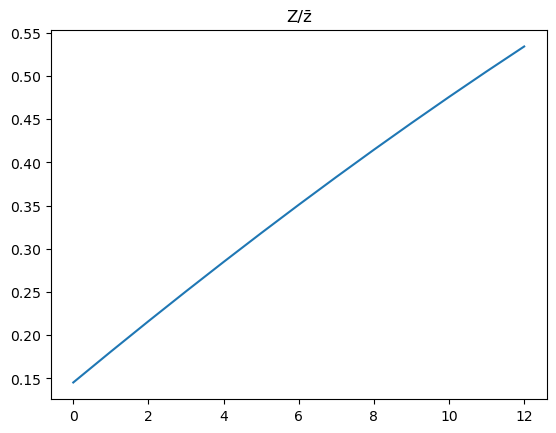

In [98]:
plt.plot(x_history[0:n,:].T/z̄)
plt.title('Z/z̄')